# Import Necessary Librires 

In [3]:
import pandas as pd
import numpy as np
import  mlflow.sklearn
import matplotlib.pyplot as plt
import mlflow, argparse, joblib, warnings, itertools, pickle
warnings.filterwarnings('ignore')

# metrix,
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, accuracy_score, f1_score

#Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import xgboost as xgb

#Models
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

# Loading Data

In [2]:
df = pd.read_parquet(r"../data/V6_ReduceDimension_Data.parquet")
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,taxi_demand
0,7232.423961,1.917840,3.593047,-1.520966,1.378757,1.594858,-0.398472,-0.214360,-2.450065,-0.298501,-2.372837,0.853763,-1.258673,-0.016103,-2.541717e-15,-4.228377e-14,1.265271e-17,9.903077e-21,-6.415206e-32,-0.086022
1,8450.424030,2.242227,3.789262,-0.164432,1.304658,0.776806,-0.565016,0.171054,-2.796305,-0.094508,-2.241521,1.258338,0.361904,0.040717,5.565055e-13,-2.290931e-16,-2.459113e-16,3.465575e-21,2.819584e-30,-0.086022
2,7568.423905,2.921402,3.676932,0.123669,1.305928,0.252489,-0.408997,0.327325,-2.931228,-0.347989,-2.125539,1.834953,0.778209,0.013537,-7.894685e-16,9.182485e-14,4.328383e-17,1.672041e-20,-5.235990e-31,-0.086022
3,9988.423917,4.125735,3.488578,0.979430,1.287473,-0.610574,-0.368645,0.694405,-3.199143,-0.312189,-1.877975,3.015216,1.453752,-0.073135,-2.309535e-15,1.066815e-13,-4.836991e-18,-1.045812e-19,-4.348663e-31,-0.086022
4,11093.423843,5.250869,3.348828,1.852266,1.265425,-1.525679,-0.294683,1.056983,-3.481290,-0.309485,-1.655867,4.082340,2.310911,-0.079123,1.132270e-15,1.138803e-14,4.044429e-17,-7.080540e-19,-2.756465e-30,-0.086022


In [3]:
df.shape

(8713, 20)

In [4]:
# splitig
X = df.drop(columns= ["taxi_demand",])
y = df.taxi_demand

In [5]:
# Load and preprocess your data (X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [6]:
X_train.shape, X_test.shape

((6970, 19), (1743, 19))

In [7]:
y_train.shape, y_test.shape

((6970,), (1743,))

# Experiment Tracking:

In [8]:
mlflow.set_experiment("TimeSeries")

<Experiment: artifact_location='file:///C:/Users/SRA/Desktop/backup/C/MLgrit/time_series_project/uber-taxi-demand/notebooks/c_Model/Experimentation/code/mlruns/961775791195664480', creation_time=1703003324360, experiment_id='961775791195664480', last_update_time=1703003324360, lifecycle_stage='active', name='TimeSeries', tags={}>

- Model Training and Logging:

In [9]:
# KNeighborsRegressor?

# KNeighborsRegressor

In [11]:
mlflow.set_experiment("TimeSeries")

with mlflow.start_run():
    model = KNeighborsRegressor() 

    param_grid = {
        "n_neighbors" : [1],
        "weights": ['uniform', 'distance'], # uniform gives equal or same priority for each vote, distance gives more priority for the closer vote.   
        "algorithm": ['auto'],
        "leaf_size": [30],
        "p": [2],
        "metric": ['minkowski'],
        "metric_params": [None],
        "n_jobs": [None],
    }
# GridSearchCV Each combination will try.
# RandomizedSearchCV Some random combination will try and we use it for huge data processing.
    grid = GridSearchCV(
        model,
        param_grid = param_grid,
        scoring="neg_mean_squared_error", 
        cv=5  # Number of cross-validation folds
    )
    
    grid.fit(X_train, y_train)
    
    # Log parameters
    mlflow.log_params(grid.best_params_)
    
    # Predict on the test set using the best estimator from the grid search
    y_pred = grid.best_estimator_.predict(X_test)

 # Calculate and log the evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"r2_score: {r2}")
    
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "MAPE0": mape,
        "R2_SCORE": r2
    })
    
    # Log the best model using MLflow
    # mlflow.sklearn.log_model(model, 'knn')

r2_score: 0.8744236311239193


In [12]:
score = []

for i in range(1, 16):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score.append(r2_score(y_test, y_pred))

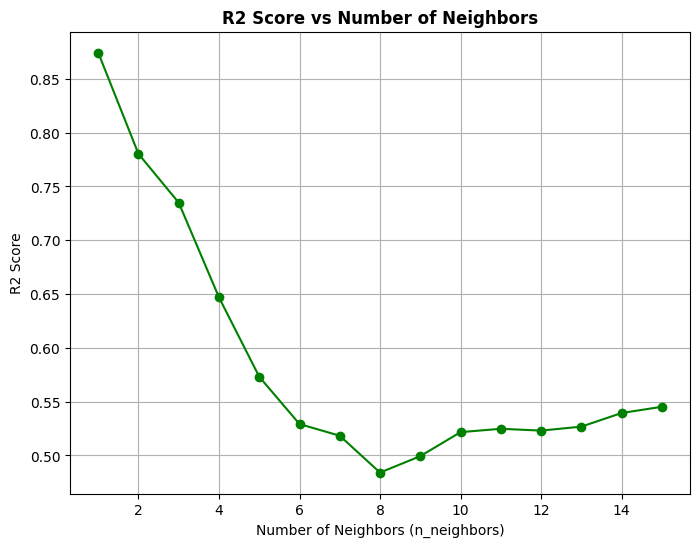

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), score, marker='o', color="green")  # Plotting n_neighbors vs R2 score
plt.title('R2 Score vs Number of Neighbors', weight="bold")
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

In [14]:
knn = KNeighborsRegressor(n_neighbors=1)  

# Initialize BaggingRegressor with KNN as the base estimator
bagging_knn = BaggingRegressor(base_estimator=knn, n_estimators=10, random_state=33)

# Fit the BaggingRegressor on the training data
bagging_knn.fit(X_train, y_train)

# Make predictions
predictions = bagging_knn.predict(X_test)

# Evaluate the performance
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2}")


R2 Score: 0.8091239193083574


# ARIMA
- Models for ARIMA (Autoregressive integrated moving average)

In [15]:
# ARIMA?

In [16]:
mlflow.set_experiment("TimeSeries")

with mlflow.start_run():
    # Fit ARIMA model with default parameters
    model = ARIMA(y_train, order=(12, 1, 2))  # Default ARIMA order
    fitted_model = model.fit()

    # Make predictions
    y_pred = fitted_model.forecast(steps=len(y_test))

    # Evaluate model
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"r2_score: {r2}")

    # Log parameters
    mlflow.log_param("order_p", 12)
    mlflow.log_param("order_d", 1)
    mlflow.log_param("order_q", 2)

    # Log metrics
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "R2_SCORE": r2
    })

    # Log the ARIMA model using MLflow
    # mlflow.statsmodels.log_model(fitted_model, "ARIMA_Model")

C:\Users\SRA\Desktop\backup\C\MLgrit\time_series_project\timeseriesENV\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SRA\Desktop\backup\C\MLgrit\time_series_project\timeseriesENV\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SRA\Desktop\backup\C\MLgrit\time_series_project\timeseriesENV\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


r2_score: -0.0019421107976038687


C:\Users\SRA\Desktop\backup\C\MLgrit\time_series_project\timeseriesENV\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# XGBoost

In [17]:
mlflow.set_experiment("TimeSeries")

with mlflow.start_run():
    model = xgb.XGBRFRegressor()

    param_grid = {
        'objective': ['reg:squarederror'],
        'colsample_bytree': [0.3],
        'learning_rate': [0.1],
        'max_depth': [5],
        'alpha': [10],
        'n_estimators': [100]
    }

    gscv = GridSearchCV(
        model,
        param_grid = param_grid,
        scoring = "neg_mean_squared_error",
        cv = 5
    )
    gscv.fit(X_train, y_train)
    
    # Log parameters
    mlflow.log_params(gscv.best_params_)
    
    # Predict on the test set using the best estimator from the grid search
    y_pred = gscv.best_estimator_.predict(X_test)

 # Calculate and log the evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"r2_score: {r2}")
    
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "MAPE0": mape,
        "R2_SCORE": r2
    })
    
    # Log the best model using MLflow
    # mlflow.sklearn.log_model(gscv, 'xgb')

r2_score: 0.09983543759496727
